### 목표
> * 딥러닝 문제 구성에 대한 기본적인 이해를 높인다.
> * Neural Network에 사용되는 용어들에 대한 이해를 높인다.
> * 딥러닝 프레임워크를 사용하지 않고, Numpy만을 이용해 딥러닝 모델과 훈련 과정을 직접 구현해 본다.

---

## MNIST 이미지 분류기 모델 예시

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터를 로드
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

# 모델에 맞게 데이터 가공
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
x_train_reshaped = x_train_norm.reshape(-1, x_train_norm.shape[1]*x_train_norm.shape[2])
x_test_reshaped = x_test_norm.reshape(-1, x_test_norm.shape[1]*x_test_norm.shape[2])

# 딥러닝 모델 구성 - 2 Layer Perceptron
model=keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))  # 입력층 d=784, 은닉층 레이어 H=50
model.add(keras.layers.Dense(10, activation='softmax'))   # 출력층 레이어 K=10
model.summary()

# 모델 구성과 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train_reshaped, y_train, epochs=10)

# 모델 테스트 결과
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-09-17 23:21:21.858776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-17 23:21:21.858869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-17 23:21:21.997369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  29/1875 [..............................] - ETA: 6s - loss: 2.1000 - accuracy: 0.4116

2022-09-17 23:21:22.101125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 7s 4ms/step - loss: 0.4933 - accuracy: 0.8835
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2309 - accuracy: 0.9347
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1806 - accuracy: 0.9487
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1499 - accuracy: 0.9570
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1282 - accuracy: 0.9638
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1127 - accuracy: 0.9679
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1005 - accuracy: 0.9712
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0904 - accuracy: 0.9737
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0826 - accuracy: 0.9764
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0750 - accurac

2022-09-17 23:22:31.193275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 - 1s - loss: 0.0994 - accuracy: 0.9702 - 1s/epoch - 3ms/step
test_loss: 0.09942743182182312 
test_accuracy: 0.9702000617980957


---

# 신경망 구조 이해

### 다층 퍼셉트론 Overview
![다층 퍼셉트론](perceptron.png)
 * 위의 이미지는 총 3개의 레이어로 구성된 퍼셉트론(위 예시 코드와도 동일)</br>
 * 은닉층에는 H개의 노드가, 출력층에는 K개의 노드가 존재하는 인공신경망.</br>(+1 부분은 bias를 뜻하는 부분이므로 이전 레이어와의 연결이 없음) 
 * 위의 코드에서는 H=50, K=10, 그리고 입력층 노드 개수 d=784로 정의됨.

참조 - bias term
> * [What is the role of the bias in neural networks](https://stackoverflow.com/questions/2480650/what-is-the-role-of-the-bias-in-neural-networks)

---

# 예제 모델을 Numpy로 구성해보기

#### 1-1. 우선 데이터에서 앞 5개를 가져와서 형태를 파악

In [3]:
# 입력층 데이터의 모양(shape)
print(x_train_reshaped.shape)

# 테스트를 위해 x_train_reshaped의 앞 5개의 데이터를 가져옴
X = x_train_reshaped[:5]
print(X.shape)

(60000, 784)
(5, 784)


#### 1-2. 가중치를 적용</br>
$ y = W⋅x + b $

In [4]:
weight_init_std = 0.1
input_size = 784
hidden_size = 50

# 인접 레이어간 관계를 나타내는 파라미터 W를 생성하고 random 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)  
# 바이어스 파라미터 b를 생성하고 Zero로 초기화
b1 = np.zeros(hidden_size)

a1 = np.dot(X, W1) + b1   # 은닉층 출력

print(W1.shape)
print(b1.shape)
print(np.dot(X, W1).shape)
print(a1.shape)

(784, 50)
(50,)
(5, 50)
(5, 50)


In [5]:
# 첫 번째 데이터의 은닉층 출력을 확인.
a1[0] 

#(5,50)이니 50개가 나올 것

array([-0.33450404,  0.27195513,  0.29135547,  0.34506664, -0.97033158,
       -1.21108402,  1.4524849 ,  0.33959936,  0.1616495 , -0.420301  ,
       -0.68788799, -2.08477633, -1.43647547,  3.164572  , -2.21287281,
        0.82988969, -0.23769457,  0.55451319, -0.02758834,  0.51331285,
        0.79399484, -0.01105704,  1.28846703,  1.2535227 , -1.90335295,
       -0.06927383, -1.01260457,  1.82520233, -0.83690381, -0.04715544,
       -0.95582681, -1.07258177, -0.50800332, -0.09851577, -1.40924958,
        0.72216953, -0.08316008, -1.87465683, -0.77570566,  1.2303979 ,
        1.77005472, -0.70529003,  1.04045509, -0.25188846, -0.53714441,
       -1.18334493, -1.12282484,  0.15620763,  0.08763582, -0.12042762])

#### 1-3. Sigmoid 함수 설계




참조 - 다른 활성화 함수
> * [딥러닝에서 사용하는 활성화 함수](https://reniew.github.io/12/)

In [6]:
# sigmoid 함수
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  


z1 = sigmoid(a1)
print(z1[0])  # sigmoid의 출력은 모든 element가 0에서 1사이

[0.41714513 0.56757282 0.57232794 0.58542074 0.27481442 0.2295093
 0.81038057 0.5840932  0.54032461 0.39644473 0.33450306 0.11058531
 0.19209174 0.95947908 0.09860045 0.6963316  0.44085457 0.63518205
 0.49310335 0.62558276 0.68868846 0.49723577 0.7838876  0.77790906
 0.12972946 0.48268847 0.26647044 0.8611892  0.30218728 0.48821332
 0.27771452 0.25491241 0.37566171 0.47539096 0.19635244 0.67308458
 0.47922195 0.13300381 0.31524615 0.77388821 0.85446448 0.33064041
 0.73893781 0.43735874 0.36885211 0.2344513  0.24548768 0.53897269
 0.52189494 0.46992943]


In [7]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

In [8]:
input_size = 784
hidden_size = 50
output_size = 10

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)    # z1이 다시 두번째 레이어의 입력이 됩니다. 

print(a1.shape)
print(a2.shape)
print(a2[0])

(5, 50)
(5, 10)
[-0.06501256  0.00536433  0.17488652  0.21017798 -0.18300362  0.25731827
 -0.1776017  -0.06245718  0.25231994 -0.4252272 ]


#### 1-4. 출력값에 Sigmoid 적용

In [9]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

print(a2[0].shape)
print(a2[0].ndim)

(10,)
1


In [11]:
y_hat = softmax(a2)
y_hat[0]  

# 10개의 숫자 중 하나일 확률이 됨

array([0.09176903, 0.09846014, 0.11664953, 0.12083977, 0.0815555 ,
       0.12667259, 0.08199725, 0.09200383, 0.12604102, 0.06401134])

#### 1-5. One-Hot Encoding 적용

In [12]:
# 정답 라벨을 One-hot 인코딩하는 함수
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

Y_digit = y_train[:5]
t = _change_one_hot_label(Y_digit, 10)
t     # 정답 라벨의 One-hot 인코딩

print(t)   #One-hot 인코딩을 한 결과물
print(Y_digit)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[5 0 4 1 9]


In [13]:
print(y_hat[0])
print(t[0])

[0.09176903 0.09846014 0.11664953 0.12083977 0.0815555  0.12667259
 0.08199725 0.09200383 0.12604102 0.06401134]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#### 1-6. Cross Entropy 손실함수 적용

In [14]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

Loss = cross_entropy_error(y_hat, t)
Loss

2.383042991234002

---

#### 2. 이어서 경사하강법 적용(Numpy 이어서)

In [15]:
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num
dy    

# softmax값의 출력으로 Loss를 미분한 값

array([[ 0.01835381,  0.01969203,  0.02332991,  0.02416795,  0.0163111 ,
        -0.17466548,  0.01639945,  0.01840077,  0.0252082 ,  0.01280227],
       [-0.18288289,  0.0214242 ,  0.02235758,  0.02753031,  0.0152298 ,
         0.02988222,  0.01482419,  0.01995497,  0.01831775,  0.01336187],
       [ 0.0214381 ,  0.01899003,  0.02516971,  0.02444306, -0.18299748,
         0.0247583 ,  0.01245979,  0.01860767,  0.02317354,  0.01395729],
       [ 0.02275719, -0.17644103,  0.02066328,  0.01837704,  0.0197757 ,
         0.02452389,  0.01044128,  0.02063471,  0.02457295,  0.014695  ],
       [ 0.02012187,  0.02229394,  0.01876543,  0.02213261,  0.01792471,
         0.02116997,  0.01882422,  0.02206999,  0.02437684, -0.18767959]])

#### * dy는 $ { ∂Loss \over ∂y} $, dX란 $ { ∂Loss \over ∂X} $를 의미
#### * dy를 구하고 다른 기울기는 chain-rule을 이용해 계산
 * ${∂Loss \over ∂W2} = {∂Loss \over ∂y}{∂y \over ∂W2} $
 * y = W2⋅z1+b2
 * ${∂Loss \over ∂W2} $= dy⋅z1
 


In [16]:
dW2 = np.dot(z1.T, dy)    
dW2

array([[-0.01526192, -0.06894572,  0.04895061,  0.05000895, -0.08146747,
        -0.03460028,  0.03015195,  0.04296322,  0.05111221, -0.02291155],
       [-0.04293871, -0.04458247,  0.05962624,  0.0627062 , -0.07470826,
        -0.05089654,  0.03906809,  0.05322006,  0.06235805, -0.06385266],
       [-0.01906457, -0.0427956 ,  0.04149622,  0.04275436, -0.08160462,
        -0.01940581,  0.02572941,  0.03630976,  0.04286913, -0.02628827],
       [-0.0069204 , -0.07769968,  0.04287647,  0.04370158, -0.04039367,
        -0.04858374,  0.02697824,  0.03830502,  0.04584721, -0.02411104],
       [-0.03122028, -0.07126748,  0.07505462,  0.07839836, -0.09008981,
        -0.0654227 ,  0.04937049,  0.06752868,  0.07961929, -0.09197117],
       [-0.06826653, -0.0950232 ,  0.04945823,  0.05220646, -0.00488801,
        -0.01828083,  0.03229819,  0.04598477,  0.05241008, -0.04589914],
       [-0.03476029, -0.05192121,  0.05240537,  0.05463713, -0.04619106,
        -0.08044529,  0.03383627,  0.04612089

In [21]:
dW2 = np.dot(z1.T, dy)
db2 = np.sum(dy, axis=0)

In [22]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

# 중간에 Sigmoid가 쓰였으므로, 활성화 함수의 gradient를 고려해야 함

In [23]:
dz1 = np.dot(dy, W2.T)
da1 = sigmoid_grad(a1) * dz1
dW1 = np.dot(X.T, da1)
db1 = np.sum(dz1, axis=0)

#### learning rate 설정

In [24]:
learning_rate = 0.1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

---

#### 3-1. 오차역전파를 적용

![오차역전파](backpropagation.png)

In [25]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

In [26]:
# 파라미터 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

# Forward Propagation
a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)

# 추론과 오차(Loss) 계산
y_hat = softmax(a2)
t = _change_one_hot_label(Y_digit, 10)   # 정답 One-hot 인코딩
Loss = cross_entropy_error(y_hat, t)

print(y_hat)
print(t)
print('Loss: ', Loss)
        
dy = (y_hat - t) / X.shape[0]
dz1, dW2, db2 = affine_layer_backward(dy, cache2)
da1 = sigmoid_grad(a1) * dz1
dX, dW1, db1 = affine_layer_backward(da1, cache1)

# 경사하강법을 통한 파라미터 업데이트    
learning_rate = 0.1
W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

[[0.10430899 0.16060289 0.14567277 0.06399407 0.0646721  0.07446101
  0.08432574 0.06805646 0.14045203 0.09345394]
 [0.10880614 0.16425695 0.1651156  0.07384793 0.09076073 0.07104537
  0.06520881 0.06030134 0.11325799 0.08739915]
 [0.11126667 0.18739787 0.16110897 0.06752471 0.07536272 0.05957209
  0.08469122 0.0635309  0.09549968 0.09404517]
 [0.09732947 0.14596552 0.15489989 0.06481262 0.08203828 0.07884836
  0.09617142 0.07637728 0.12138547 0.0821717 ]
 [0.09550304 0.18815339 0.1789187  0.06611471 0.0748957  0.05563005
  0.09154891 0.06009621 0.10724751 0.08189178]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.365570236656284


#### 3-2. 학습을 반복

In [27]:
# 총 다섯 스탭을 반복할 것

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1)
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2)
    t = _change_one_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat)
        print(t)
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2)
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [28]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복 돌립니다.
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.11756542 0.09167559 0.04816777 0.11284793 0.06898041 0.10756702
  0.1258855  0.07217725 0.17032569 0.08480743]
 [0.13515665 0.08584594 0.04588368 0.09681836 0.05299074 0.12165549
  0.14392084 0.06169166 0.1826945  0.07334214]
 [0.13363313 0.07454445 0.04526107 0.11452054 0.05683823 0.10460633
  0.13072471 0.06866396 0.20853847 0.06266911]
 [0.13106188 0.09062455 0.05504815 0.11465372 0.06328174 0.13176756
  0.11826195 0.06330922 0.1475443  0.08444693]
 [0.11054092 0.09060125 0.04625032 0.12987613 0.06008888 0.10731633
  0.11101022 0.06153901 0.17319019 0.10958676]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.3421153814459545
---------
[[0.13345153 0.10606361 0.04578933 0.09873969 0.08409376 0.12656966
  0.10775873 0.0664823  0.13321918 0.09783222]
 [0.16110259 0.10085415 0.04364498 0.08332871 0.06582133 0.13917972
  0.12178917 0.05682536 0.140

=> Loss가 줄어드는 것을 확인 가능



---



#### 4-1. Predict / Accuracy 계산

In [29]:
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [30]:
# X = x_train[:100] 에 대해 모델 추론을 시도합니다. 
X = x_train_reshaped[:100]
Y = y_test[:100]
result = predict(W1, b1, W2, b2, X)
result[0]

array([0.16264332, 0.1373762 , 0.03296222, 0.05958404, 0.13213137,
       0.18007485, 0.06211005, 0.04391578, 0.06379055, 0.12541163])

In [31]:
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

In [32]:
acc = accuracy(W1, b1, W2, b2, X, Y)

t = _change_one_hot_label(Y, 10)
print(result[0])
print(t[0])
print(acc)

[0.16264332 0.1373762  0.03296222 0.05958404 0.13213137 0.18007485
 0.06211005 0.04391578 0.06379055 0.12541163]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.1


#### 4-2. 전체 학습 사이클 수행

In [33]:
def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):

    W1 = weight_init_std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    print(W1.shape)
    print(b1.shape)
    print(W2.shape)
    print(b2.shape)
    
    return W1, b1, W2, b2

In [34]:
# 하이퍼파라미터
iters_num = 50000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 50, 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train_reshaped[batch_mask]
    y_batch = y_train[batch_mask]
    
    W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate=0.1, verbose=False)

    # 학습 경과 기록
    train_loss_list.append(Loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        print('Loss: ', Loss)
        train_acc = accuracy(W1, b1, W2, b2, x_train_reshaped, y_train)
        test_acc = accuracy(W1, b1, W2, b2, x_test_reshaped, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

(784, 50)
(50,)
(50, 10)
(10,)
Loss:  2.3037488700105326
train acc, test acc | 0.10218333333333333, 0.101
Loss:  0.8876065129761714
train acc, test acc | 0.79475, 0.7976
Loss:  0.4780313246802402
train acc, test acc | 0.8781166666666667, 0.883
Loss:  0.3163470311371709
train acc, test acc | 0.8980833333333333, 0.901
Loss:  0.23786216652177544
train acc, test acc | 0.9074, 0.9121
Loss:  0.1669713180483278
train acc, test acc | 0.91405, 0.918
Loss:  0.33076439510337585
train acc, test acc | 0.9207166666666666, 0.923
Loss:  0.27351421278264504
train acc, test acc | 0.9246166666666666, 0.927
Loss:  0.32236020942149474
train acc, test acc | 0.9282166666666667, 0.93
Loss:  0.17401190925957238
train acc, test acc | 0.9311333333333334, 0.9321
Loss:  0.1555124796131355
train acc, test acc | 0.9348, 0.935
Loss:  0.23288828593492134
train acc, test acc | 0.9372, 0.9376
Loss:  0.14840459795229188
train acc, test acc | 0.9384166666666667, 0.9392
Loss:  0.1484807733947692
train acc, test acc | 0.941

#### 5. 시각화

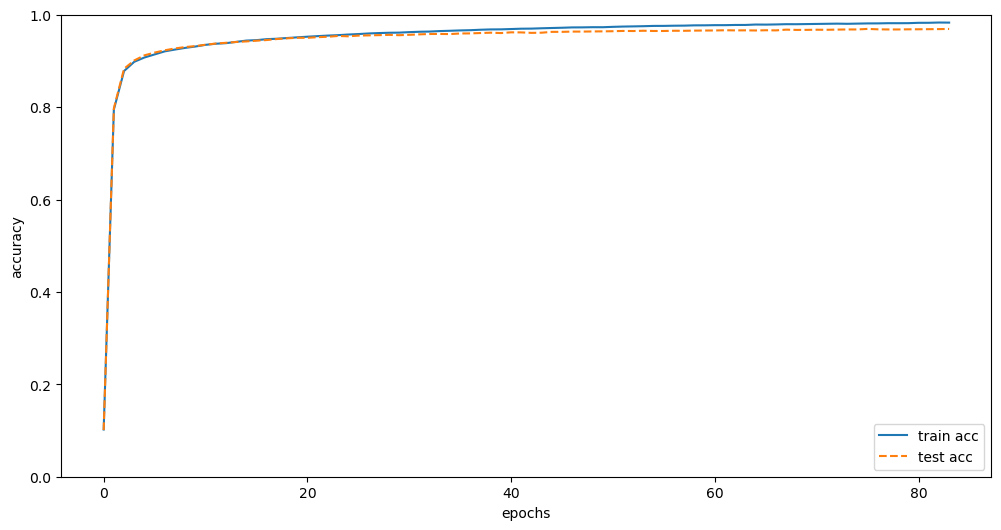

In [37]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6 

# Accuracy 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

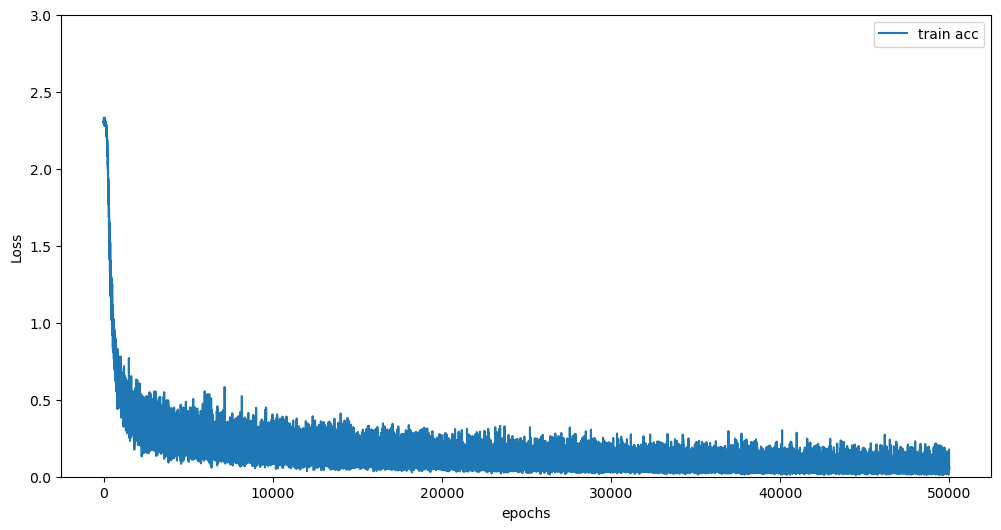

In [38]:
# Loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()